# Recommending Films for Box Office Success!

![image](https://vip-go.premiumbeat.com/wp-content/uploads/2022/02/vr_2.jpg)

*Image by DOP Eben Bolter on the LED volume stage at Rebellion Film Studios in Oxford, UK.*

## Overview

Our company sees competitors creating original video content and now wants to join the market trend. We create a new film studio despite the lack of knowledge in everything related to movies.

As the data scientist of the company, my goal is to explore what types of films are currently performing the best at the box office and with my findings – create actionable insights that the company's new studio can use to decide what type of films to create.

## Challenge

With the task at hand, we will be presenting to our company stakeholders three different recommendations that will directly affect our business revenue. The goal is to provide data-driven direction for our new film studio using evidence that our recommendations will result in truly benefitting the company.

## Datasets

In the folder `zippedData`, we have datasets from:

- [IMDB](https://www.imdb.com/)
- [The Numbers](https://www.the-numbers.com/)

## Data Understanding

This project uses statistical analysis, including formulating three hypotheses of what contributes to a film's success. We infer three different business recommendations and use box-office data to prove our hypotheses and provide statistics as evidence to support our recommendations for the company and the direction for our new film studio.

# Code

## Loading Tools

Import our datascience tools.

In [1]:
import itertools
import numpy as np
import pandas as pd 
from numbers import Number
import sqlite3
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import zipfile
import os
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.float_format', '{:,.2f}'.format)

## Loading Datasets

### IMdb, SQL Database

IMdb aims to collect any and all data of all films to showcase everyday people.

In [2]:
zip_path = 'zippedData/im.db.zip'
extract_path = 'zippedData/'

with zipfile.ZipFile(zip_path,'r') as zip_ref:
    zip_ref.extractall(extract_path)

db_path = os.path.join(extract_path, 'im.db')

conn = sqlite3.connect(db_path)
pd.read_sql("""
    SELECT *
    FROM sqlite_master
    WHERE type = 'table';
""",conn)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [3]:
df_imdb = pd.read_sql("""
    SELECT *
    FROM movie_basics AS mb
    INNER JOIN movie_ratings AS mr ON mb.movie_id =mr.movie_id;
""",conn)
df_imdb['title'] = df_imdb['primary_title']
df_imdb

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,movie_id,averagerating,numvotes,title
0,tt0063540,Sunghursh,Sunghursh,2013,175.00,"Action,Crime,Drama",tt0063540,7.00,77,Sunghursh
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama",tt0066787,7.20,43,One Day Before the Rainy Season
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00,Drama,tt0069049,6.90,4517,The Other Side of the Wind
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",tt0069204,6.10,13,Sabse Bada Sukh
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00,"Comedy,Drama,Fantasy",tt0100275,6.50,119,The Wandering Soap Opera
...,...,...,...,...,...,...,...,...,...,...
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.00,Documentary,tt9913084,6.20,6,Diabolik sono io
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.00,"Drama,Family",tt9914286,8.70,136,Sokagin Çocuklari
73853,tt9914642,Albatross,Albatross,2017,NaN,Documentary,tt9914642,8.50,8,Albatross
73854,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,None,tt9914942,6.60,5,La vida sense la Sara Amat


### TheNumbers, CSV

TheNumbers goal is to collect the most accurate details of any film's budgets and revenues.

In [4]:
df_tn_movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
df_tn_movie_budgets['title'] = df_tn_movie_budgets['movie']
df_tn_movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,title
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",Avatar
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",Pirates of the Caribbean: On Stranger Tides
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",Dark Phoenix
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",Avengers: Age of Ultron
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",Star Wars Ep. VIII: The Last Jedi
...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0,Red 11
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495",Following
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338",Return to the Land of Wonders
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0,A Plague So Pleasant


### Merge Data For Analysis

Reasons for Combined Data
- It was neccessary we `merge` our data from `IMdb` and `TheNumbers` because IMdb is a popular platform that houses all details of films, including genres, ratings, and votes and TheNumbers has reliable information regarding film budgets and revenues across the world.
- By combining these two datasets, we couple our data of `films`, `genres`, `ratings`, and `votes` with `financial data` to help us investigate deeper in our analysis.

In [5]:
df_box_office = pd.merge(df_imdb, df_tn_movie_budgets, on='title', how='inner')
df_box_office

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,movie_id,averagerating,numvotes,title,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,tt0249516,Foodfight!,Foodfight!,2012,91.00,"Action,Animation,Comedy",tt0249516,1.90,8248,Foodfight!,26,"Dec 31, 2012",Foodfight!,"$45,000,000",$0,"$73,706"
1,tt0326592,The Overnight,The Overnight,2010,88.00,None,tt0326592,7.50,24,The Overnight,21,"Jun 19, 2015",The Overnight,"$200,000","$1,109,808","$1,165,996"
2,tt0337692,On the Road,On the Road,2012,124.00,"Adventure,Drama,Romance",tt0337692,6.10,37886,On the Road,17,"Mar 22, 2013",On the Road,"$25,000,000","$720,828","$9,313,302"
3,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.00,"Adventure,Comedy,Drama",tt0359950,7.30,275300,The Secret Life of Walter Mitty,37,"Dec 25, 2013",The Secret Life of Walter Mitty,"$91,000,000","$58,236,838","$187,861,183"
4,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.00,"Action,Crime,Drama",tt0365907,6.50,105116,A Walk Among the Tombstones,67,"Sep 19, 2014",A Walk Among the Tombstones,"$28,000,000","$26,017,685","$62,108,587"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2870,tt9746500,Earth,Erde,2019,115.00,Documentary,tt9746500,7.30,49,Earth,36,"Apr 22, 2009",Earth,"$47,000,000","$32,011,576","$116,773,317"
2871,tt9851050,Sisters,Sisters,2019,NaN,"Action,Drama",tt9851050,4.70,14,Sisters,57,"Dec 18, 2015",Sisters,"$30,000,000","$87,044,645","$106,030,660"
2872,tt9861522,Ali,Ali,2019,110.00,Drama,tt9861522,7.70,79,Ali,45,"Dec 25, 2001",Ali,"$109,000,000","$58,183,966","$87,683,966"
2873,tt9899880,Columbus,Columbus,2018,85.00,Comedy,tt9899880,5.80,5,Columbus,93,"Aug 4, 2017",Columbus,"$700,000","$1,017,107","$1,110,511"


# Exploratory Data Analysis

### 1. Understanding The Data
- Dataframe `shape`
- `head` and `tail`
- `info`
- `describe`

In [6]:
df_box_office.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,movie_id,averagerating,numvotes,title,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,tt0249516,Foodfight!,Foodfight!,2012,91.00,"Action,Animation,Comedy",tt0249516,1.90,8248,Foodfight!,26,"Dec 31, 2012",Foodfight!,"$45,000,000",$0,"$73,706"
1,tt0326592,The Overnight,The Overnight,2010,88.00,None,tt0326592,7.50,24,The Overnight,21,"Jun 19, 2015",The Overnight,"$200,000","$1,109,808","$1,165,996"
2,tt0337692,On the Road,On the Road,2012,124.00,"Adventure,Drama,Romance",tt0337692,6.10,37886,On the Road,17,"Mar 22, 2013",On the Road,"$25,000,000","$720,828","$9,313,302"
3,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.00,"Adventure,Comedy,Drama",tt0359950,7.30,275300,The Secret Life of Walter Mitty,37,"Dec 25, 2013",The Secret Life of Walter Mitty,"$91,000,000","$58,236,838","$187,861,183"
4,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.00,"Action,Crime,Drama",tt0365907,6.50,105116,A Walk Among the Tombstones,67,"Sep 19, 2014",A Walk Among the Tombstones,"$28,000,000","$26,017,685","$62,108,587"


In [7]:
df_box_office.shape

(2875, 16)

In [8]:
df_box_office.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2875 entries, 0 to 2874
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           2875 non-null   object 
 1   primary_title      2875 non-null   object 
 2   original_title     2875 non-null   object 
 3   start_year         2875 non-null   int64  
 4   runtime_minutes    2757 non-null   float64
 5   genres             2867 non-null   object 
 6   movie_id           2875 non-null   object 
 7   averagerating      2875 non-null   float64
 8   numvotes           2875 non-null   int64  
 9   title              2875 non-null   object 
 10  id                 2875 non-null   int64  
 11  release_date       2875 non-null   object 
 12  movie              2875 non-null   object 
 13  production_budget  2875 non-null   object 
 14  domestic_gross     2875 non-null   object 
 15  worldwide_gross    2875 non-null   object 
dtypes: float64(2), int64(3),

In [9]:
df_box_office.describe()

,start_year,runtime_minutes,averagerating,numvotes,id
count,"2,875.00","2,757.00","2,875.00","2,875.00","2,875.00"
mean,"2,013.92",102.95,6.25,"66,280.38",50.94
std,2.55,20.79,1.19,"134,307.71",28.70
min,"2,010.00",3.00,1.60,5.00,1.00
25%,"2,012.00",90.00,5.60,141.00,27.00
50%,"2,014.00",101.00,6.40,"7,951.00",51.00
75%,"2,016.00",113.00,7.10,"75,081.00",76.00
max,"2,019.00",280.00,9.30,"1,841,066.00",100.00


### 2. Data Preparation
- Dropping irrelevant columns and rows
- Identifying duplicated columns
- Renaming columns
- Feature creation

Let's clean up our dataset by `dropping` irrelevant `columns` and `renaming` them to represent the data better.

In [10]:
df = df_box_office[[
    # 'movie_id', 'original_title', 'start_year', 
    # 'runtime_minutes', 'movie_id', 'title', 'id', 'movie'
    'primary_title',  'genres', 'averagerating', 'numvotes', 
    'release_date', 'production_budget', 'worldwide_gross' ]]

df.rename(columns={ 'primary_title':'film', 'averagerating':'rating', 'numvotes':'votes', 
                    'release_date':'release', 'production_budget':'budget',
                    'worldwide_gross':'revenue' }, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2875 entries, 0 to 2874
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   film     2875 non-null   object 
 1   genres   2867 non-null   object 
 2   rating   2875 non-null   float64
 3   votes    2875 non-null   int64  
 4   release  2875 non-null   object 
 5   budget   2875 non-null   object 
 6   revenue  2875 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 157.4+ KB


There are some important data preparation we need to do:
- Replace `genre` values that are `NaN` with string `'unknown'` if data is missing. This way we are not losing any data even if we don't know the genre.
- Convert `release` to pandas `datetime` so that we can do some logical operations over it for deeper investigation.
- Convert `budget` and `revenue` into `int` so that we can do logical operations over the data for better analysis.
- Create new feature `profit` so that we better understand film financials.
- Normalize `rating` because the feature is directly affected by `votes` which disproportianately affects the true rating.

In [11]:
df['genres'].fillna('unknown', inplace=True)
df.genres

0       Action,Animation,Comedy
1                       unknown
2       Adventure,Drama,Romance
3        Adventure,Comedy,Drama
4            Action,Crime,Drama
                 ...           
2870                Documentary
2871               Action,Drama
2872                      Drama
2873                     Comedy
2874                Documentary
Name: genres, Length: 2875, dtype: object

In [12]:
mask = pd.to_datetime(df['release'], format='%b %d, %Y')
df['release'] = mask
df.release

0      2012-12-31
1      2015-06-19
2      2013-03-22
3      2013-12-25
4      2014-09-19
          ...    
2870   2009-04-22
2871   2015-12-18
2872   2001-12-25
2873   2017-08-04
2874   2010-11-12
Name: release, Length: 2875, dtype: datetime64[ns]

In [13]:
mask = df['budget'].str.strip('$').str.replace(',','').astype(float)
df['budget'] = mask
mask = df['revenue'].str.strip('$').str.replace(',','').astype(float)
df['revenue'] = mask
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2875 entries, 0 to 2874
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   film     2875 non-null   object        
 1   genres   2875 non-null   object        
 2   rating   2875 non-null   float64       
 3   votes    2875 non-null   int64         
 4   release  2875 non-null   datetime64[ns]
 5   budget   2875 non-null   float64       
 6   revenue  2875 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 157.4+ KB


In [14]:
df.head()

,film,genres,rating,votes,release,budget,revenue
0,Foodfight!,"Action,Animation,Comedy",1.90,8248,2012-12-31,"45,000,000.00","73,706.00"
1,The Overnight,unknown,7.50,24,2015-06-19,"200,000.00","1,165,996.00"
2,On the Road,"Adventure,Drama,Romance",6.10,37886,2013-03-22,"25,000,000.00","9,313,302.00"
3,The Secret Life of Walter Mitty,"Adventure,Comedy,Drama",7.30,275300,2013-12-25,"91,000,000.00","187,861,183.00"
4,A Walk Among the Tombstones,"Action,Crime,Drama",6.50,105116,2014-09-19,"28,000,000.00","62,108,587.00"


We will be creating a `new feature` to represent the `profit` the film made by taking the `difference` between each film's `budget` and `revenue`. This reasons for this new feature is:
- The feature `profit` will immediately show us whether a movie resulted in a loss or profit.
- We can compare actual `revenue` earned between films for better analysis.
- The `profit` will tell us if `budget` plays a role in `revenue` and the film's success.
- We also want to only work with the `top 60%` of profit belonging to the data.
- We lastly `filter` the dataframe with films of only the `top 60%` of `profit` because our goal is to analyze the data that leads to great profits, which will be found in the higher grossing films.

In [15]:
df['profit'] = df['revenue'] - df['budget']
df.tail()

,film,genres,rating,votes,release,budget,revenue,profit
2870,Earth,Documentary,7.30,49,2009-04-22,"47,000,000.00","116,773,317.00","69,773,317.00"
2871,Sisters,"Action,Drama",4.70,14,2015-12-18,"30,000,000.00","106,030,660.00","76,030,660.00"
2872,Ali,Drama,7.70,79,2001-12-25,"109,000,000.00","87,683,966.00","-21,316,034.00"
2873,Columbus,Comedy,5.80,5,2017-08-04,"700,000.00","1,110,511.00","410,511.00"
2874,Unstoppable,Documentary,8.10,8,2010-11-12,"95,000,000.00","165,720,921.00","70,720,921.00"


Finding the `top 60%` of the `profit` feature.

In [16]:
top_60_percent = df['profit'].quantile(0.6)
mask = df[df['profit'] >= top_60_percent]
mask.shape

(1150, 8)

Essential `reset` of the dataframe to only be the films that reflect the `top 60%` of `profits` from the original data.

In [17]:
df = mask.sort_values(by='profit', ascending=False).reset_index(drop=True).copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   film     1150 non-null   object        
 1   genres   1150 non-null   object        
 2   rating   1150 non-null   float64       
 3   votes    1150 non-null   int64         
 4   release  1150 non-null   datetime64[ns]
 5   budget   1150 non-null   float64       
 6   revenue  1150 non-null   float64       
 7   profit   1150 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 72.0+ KB


We have two columns `rating` and `votes` that directly are affected by each other. This makes our analysis a little difficult because films with significantly less votes will affect comparing ratings with films that got a much larger number of votes.

For that reason, we created a new feature `weighted_rating` which accurately represents the film rating based on the amounts of votes the film received. This feature has been normalized throughout the data.

In [18]:
print('df.rating.describe()')
print(df['rating'].describe())
print()
print('df.votes.describe()')
print(df['votes'].describe())

df.rating.describe()
count   1,150.00
mean        6.46
std         1.10
min         1.60
25%         5.90
50%         6.50
75%         7.20
max         9.30
Name: rating, dtype: float64

df.votes.describe()
count       1,150.00
mean      132,206.87
std       183,941.88
min             5.00
25%           554.75
50%        72,527.00
75%       181,940.50
max     1,841,066.00
Name: votes, dtype: float64


In [19]:
C = df['rating'].mean()
m = df['votes'].quantile(0.6) # Only considering votes that are greater than the bottom 60%.

def weighted_rating(x, m=m, C=C):
    v = x['votes']
    R = x['rating']
    return (v / (v + m) * R) + (m / (v + m) * C)

df['weighted_rating'] = df.apply(weighted_rating, axis=1)
df[['film', 'rating', 'votes', 'weighted_rating']]

,film,rating,votes,weighted_rating
0,Avatar,6.10,43,6.46
1,Titanic,6.20,20,6.46
2,Avengers: Infinity War,8.50,670926,8.23
3,Jurassic World,7.00,539338,6.91
4,Furious 7,7.20,335074,7.02
...,...,...,...,...
1145,The One,5.40,143,6.46
1146,The One,5.00,681,6.45
1147,Max,5.10,248,6.45
1148,Max,6.80,23976,6.52


We apply the changes onto our original dataframe `rating` so that we don't add irrelevant features; including dropping `votes` since our rating scale has been weighted with votes. And lastly dropping duplicates in `film`.

In [20]:
df['rating'] = df['weighted_rating']
df = df[['film', 'genres', 'rating', 'release', 'budget', 'revenue', 'profit', # 'votes', 'weighted_rating'
   ]]
df.drop_duplicates(subset='film', keep='first', inplace=True)
df

,film,genres,rating,release,budget,revenue,profit
0,Avatar,Horror,6.46,2009-12-18,"425,000,000.00","2,776,345,279.00","2,351,345,279.00"
1,Titanic,Adventure,6.46,1997-12-19,"200,000,000.00","2,208,208,395.00","2,008,208,395.00"
2,Avengers: Infinity War,"Action,Adventure,Sci-Fi",8.23,2018-04-27,"300,000,000.00","2,048,134,200.00","1,748,134,200.00"
3,Jurassic World,"Action,Adventure,Sci-Fi",6.91,2015-06-12,"215,000,000.00","1,648,854,864.00","1,433,854,864.00"
4,Furious 7,"Action,Crime,Thriller",7.02,2015-04-03,"190,000,000.00","1,518,722,794.00","1,328,722,794.00"
...,...,...,...,...,...,...,...
1142,The Bye Bye Man,"Drama,Fantasy,Horror",6.14,2017-01-13,"7,400,000.00","31,187,727.00","23,787,727.00"
1143,Saving Grace,"Crime,Drama,Horror",6.46,2000-08-04,"4,000,000.00","27,786,849.00","23,786,849.00"
1145,The One,Comedy,6.46,2001-11-02,"49,000,000.00","72,689,126.00","23,689,126.00"
1147,Max,Comedy,6.45,2015-06-26,"20,000,000.00","43,658,157.00","23,658,157.00"


### 3. Feature Understanding
- Plotting Feature Distributions
    - Histogram
    - KDE
    - Boxplot

In [21]:
df

,film,genres,rating,release,budget,revenue,profit
0,Avatar,Horror,6.46,2009-12-18,"425,000,000.00","2,776,345,279.00","2,351,345,279.00"
1,Titanic,Adventure,6.46,1997-12-19,"200,000,000.00","2,208,208,395.00","2,008,208,395.00"
2,Avengers: Infinity War,"Action,Adventure,Sci-Fi",8.23,2018-04-27,"300,000,000.00","2,048,134,200.00","1,748,134,200.00"
3,Jurassic World,"Action,Adventure,Sci-Fi",6.91,2015-06-12,"215,000,000.00","1,648,854,864.00","1,433,854,864.00"
4,Furious 7,"Action,Crime,Thriller",7.02,2015-04-03,"190,000,000.00","1,518,722,794.00","1,328,722,794.00"
...,...,...,...,...,...,...,...
1142,The Bye Bye Man,"Drama,Fantasy,Horror",6.14,2017-01-13,"7,400,000.00","31,187,727.00","23,787,727.00"
1143,Saving Grace,"Crime,Drama,Horror",6.46,2000-08-04,"4,000,000.00","27,786,849.00","23,786,849.00"
1145,The One,Comedy,6.46,2001-11-02,"49,000,000.00","72,689,126.00","23,689,126.00"
1147,Max,Comedy,6.45,2015-06-26,"20,000,000.00","43,658,157.00","23,658,157.00"


#### Understanding `Budget` Feature

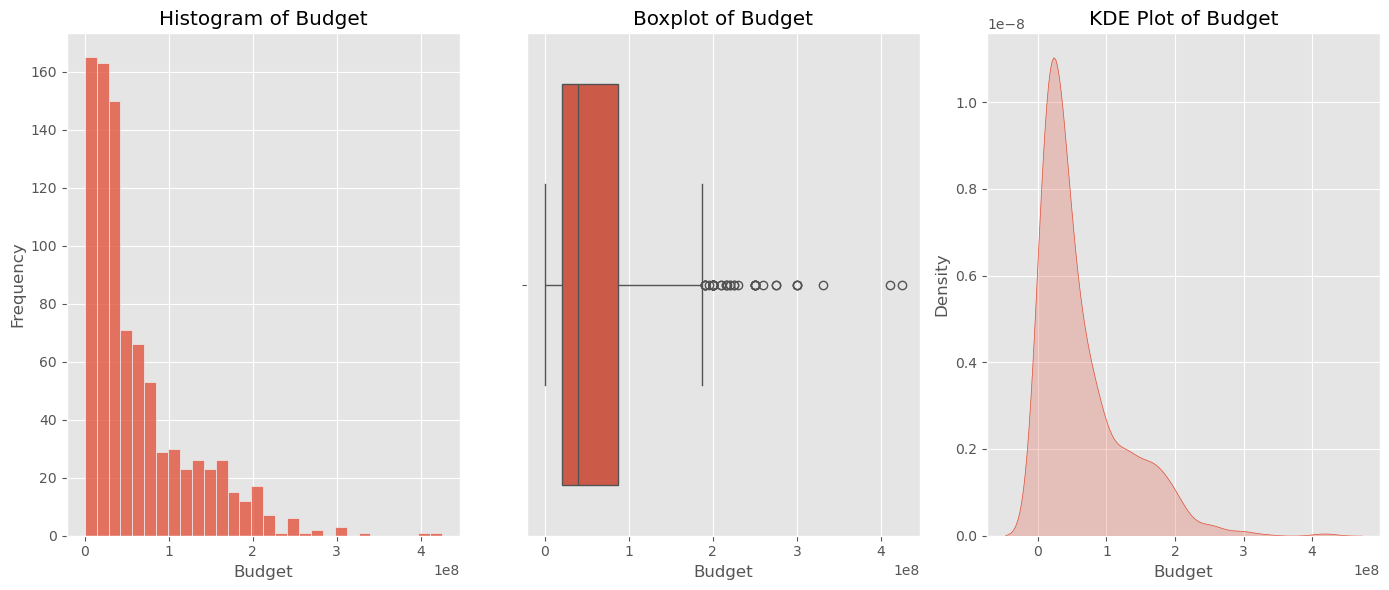

In [22]:
def visualize_df_budget():
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 3, 1)
    sns.histplot(df['budget'], kde=False, bins=30)
    plt.title('Histogram of Budget')
    plt.xlabel('Budget')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    sns.boxplot(x=df['budget'])
    plt.title('Boxplot of Budget')
    plt.xlabel('Budget')
    
    plt.subplot(1, 3, 3)
    sns.kdeplot(df['budget'], shade=True)
    plt.title('KDE Plot of Budget')
    plt.xlabel('Budget')
    
    plt.tight_layout()
    plt.show()

visualize_df_budget()

#### Understanding `Revenue` Feature

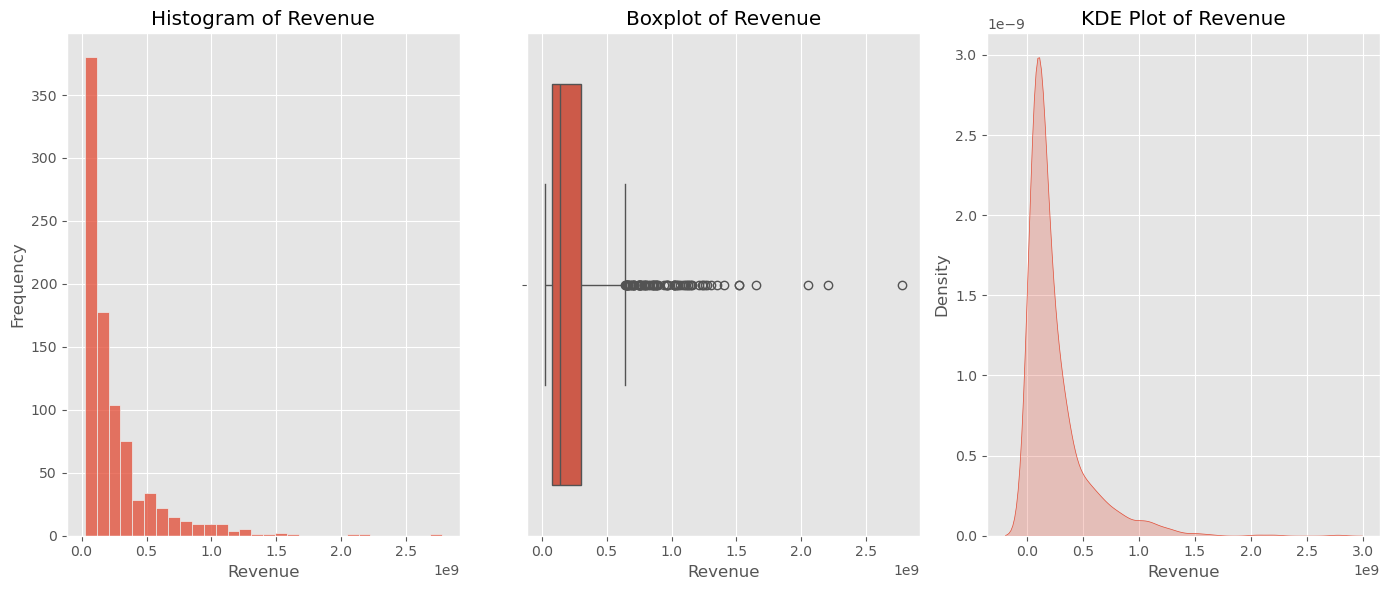

In [23]:
def visualize_df_revenue():
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 3, 1)
    sns.histplot(df['revenue'], kde=False, bins=30)
    plt.title('Histogram of Revenue')
    plt.xlabel('Revenue')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    sns.boxplot(x=df['revenue'])
    plt.title('Boxplot of Revenue')
    plt.xlabel('Revenue')
    
    plt.subplot(1, 3, 3)
    sns.kdeplot(df['revenue'], shade=True)
    plt.title('KDE Plot of Revenue')
    plt.xlabel('Revenue')
    
    plt.tight_layout()
    plt.show()

visualize_df_revenue()

#### Understanding `Profit` Feature

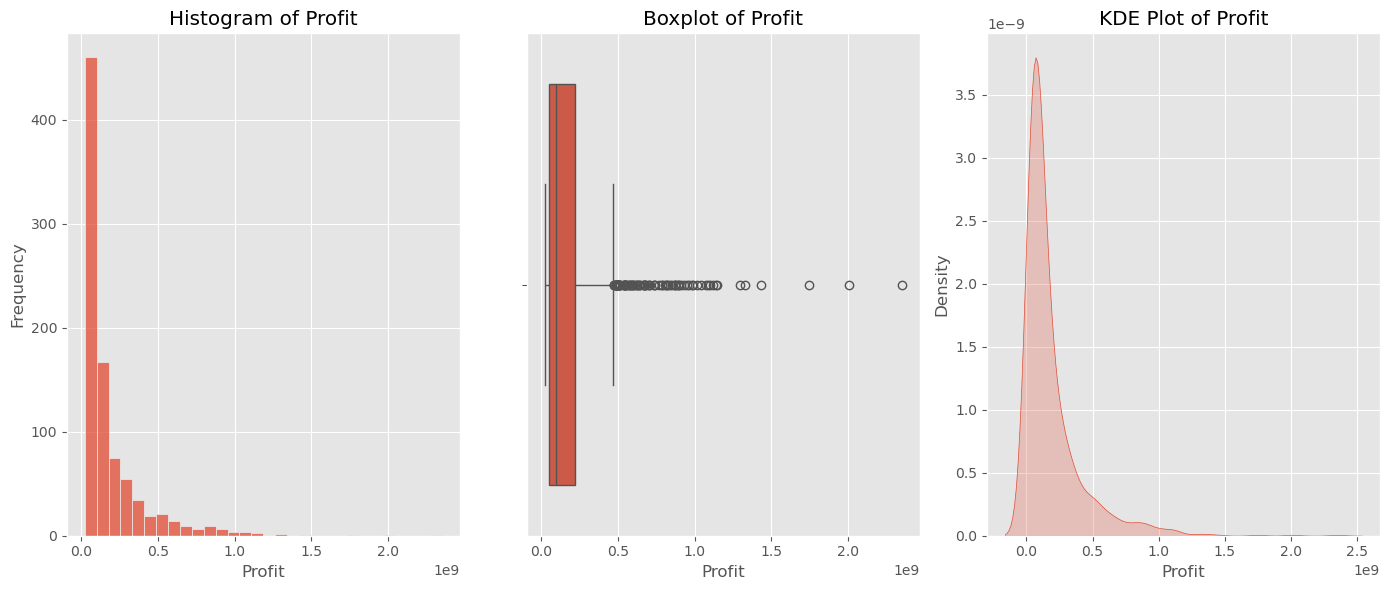

In [24]:
def visualize_df_profit():
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 3, 1)
    sns.histplot(df['profit'], kde=False, bins=30)
    plt.title('Histogram of Profit')
    plt.xlabel('Profit')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    sns.boxplot(x=df['profit'])
    plt.title('Boxplot of Profit')
    plt.xlabel('Profit')
    
    plt.subplot(1, 3, 3)
    sns.kdeplot(df['profit'], shade=True)
    plt.title('KDE Plot of Profit')
    plt.xlabel('Profit')
    
    plt.tight_layout()
    plt.show()

visualize_df_profit()

#### Understanding `Rating` Feature

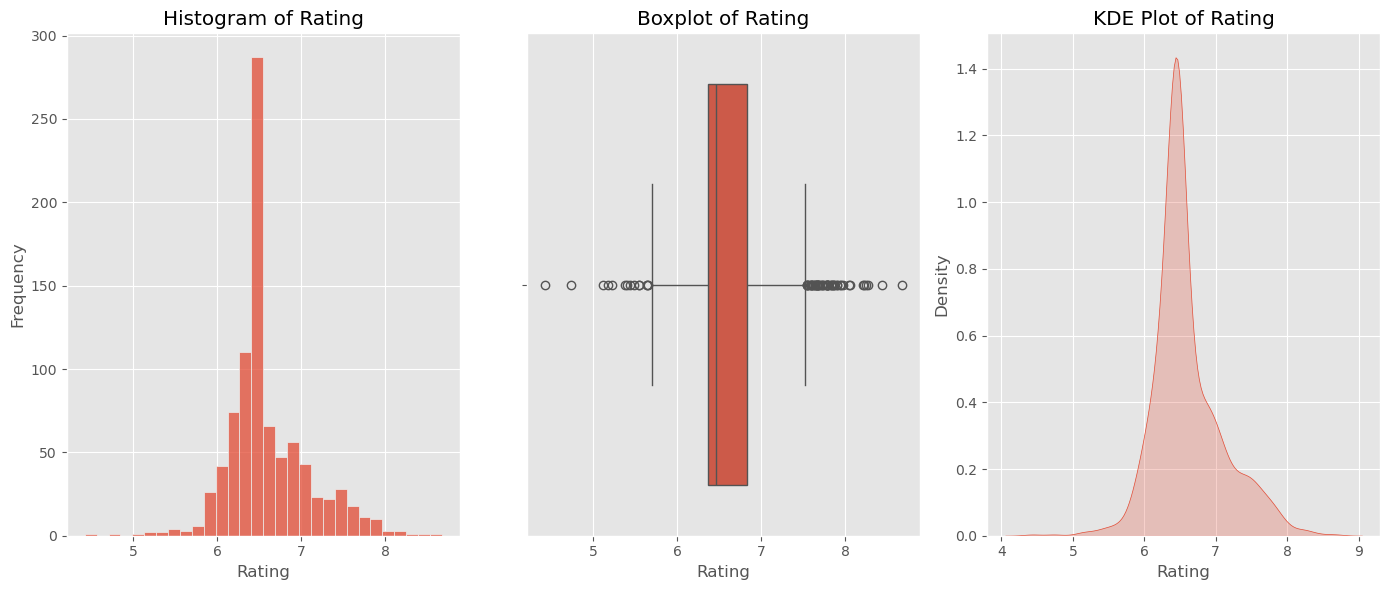

In [25]:
def visualize_df_rating():
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 3, 1)
    sns.histplot(df['rating'], kde=False, bins=30)
    plt.title('Histogram of Rating')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    sns.boxplot(x=df['rating'])
    plt.title('Boxplot of Rating')
    plt.xlabel('Rating')
    
    plt.subplot(1, 3, 3)
    sns.kdeplot(df['rating'], shade=True)
    plt.title('KDE Plot of Rating')
    plt.xlabel('Rating')
    
    plt.tight_layout()
    plt.show()

visualize_df_rating()

#### Understanding `Genres` Feature

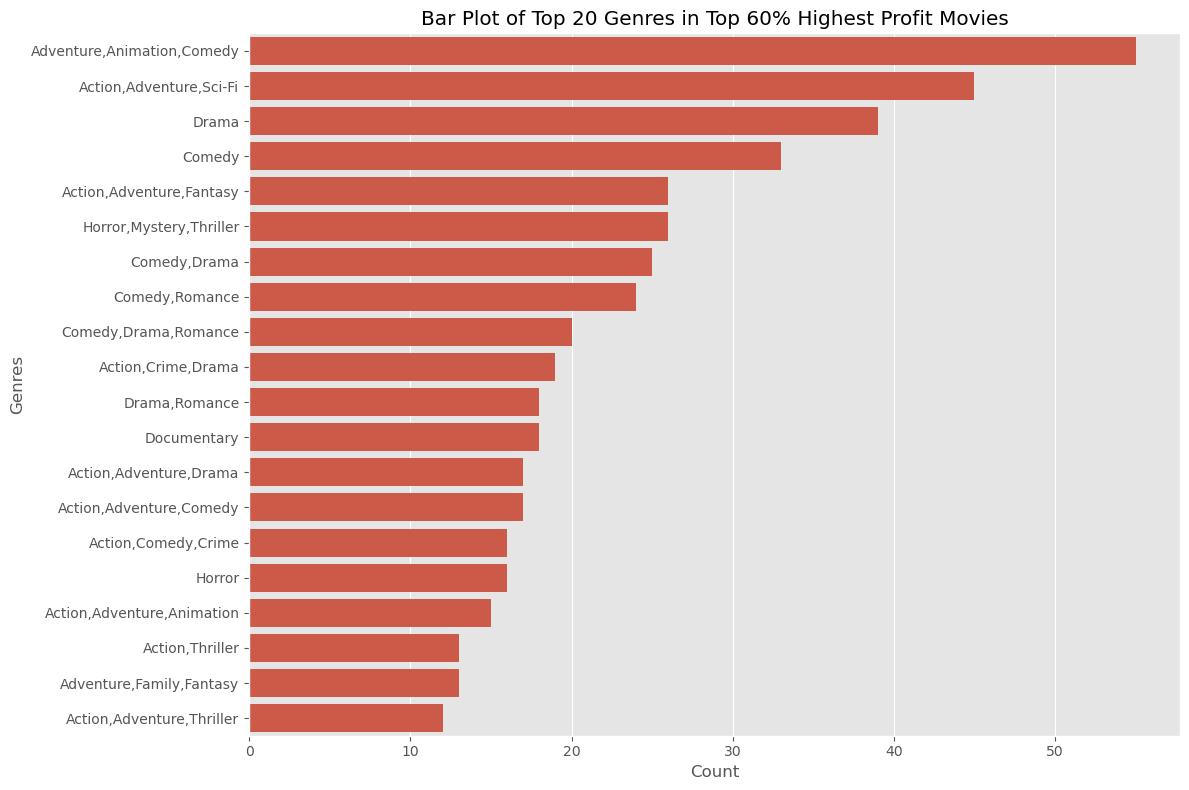

In [26]:
def visualize_df_genres():
    top_genres = df['genres'].value_counts().nlargest(20).index
    mask = df[df['genres'].isin(top_genres)]
    
    plt.figure(figsize=(12, 8))
    bar_plot = sns.countplot(y=mask['genres'], order=mask['genres'].value_counts().index)
    plt.title('Bar Plot of Top 20 Genres in Top 60% Highest Profit Movies')
    plt.xlabel('Count')
    plt.ylabel('Genres')
    
    plt.tight_layout()
    plt.show()

visualize_df_genres()

#### Understanding `Release Date` Feature

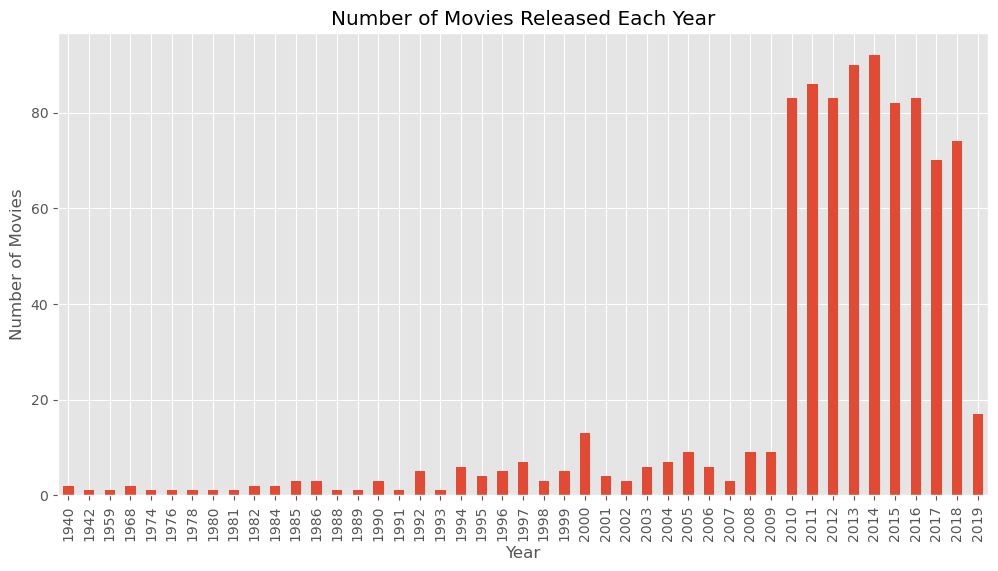

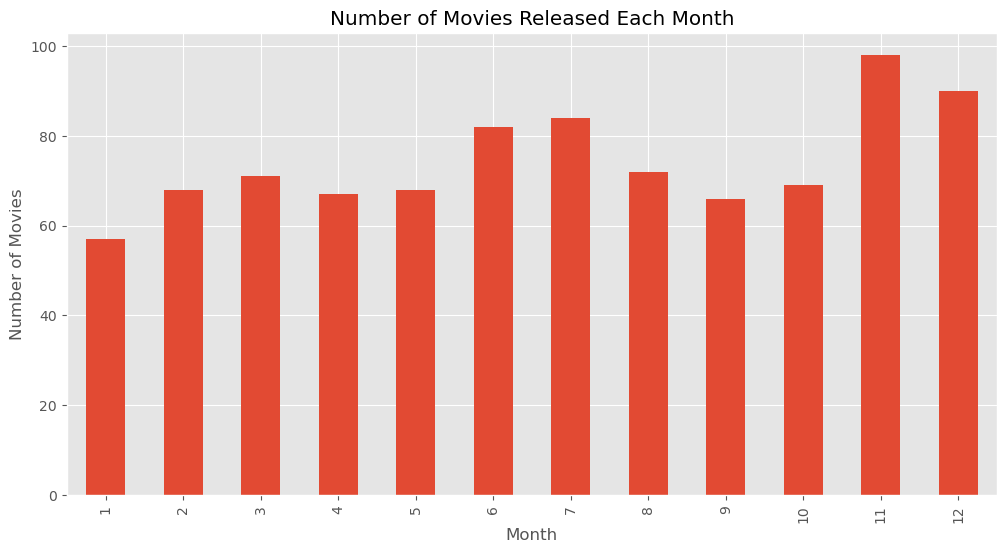

In [27]:
def visualize_df_release_year():
    df['release_year'] = df['release'].dt.year
    plt.figure(figsize=(12, 6))
    df['release_year'].value_counts().sort_index().plot(kind='bar')
    plt.title('Number of Movies Released Each Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Movies')
    plt.show()

visualize_df_release_year()

def visualize_df_release_month():
    df['release_month'] = df['release'].dt.month
    plt.figure(figsize=(12, 6))
    df['release_month'].value_counts().sort_index().plot(kind='bar')
    plt.title('Number of Movies Released Each Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Movies')
    plt.show()

visualize_df_release_month()

### 4. Feature Relationships
- Scatterplot
- Heatmap Correlation
- Pairplot
- Groupby Comparisons

In [28]:
df.head()

,film,genres,rating,release,budget,revenue,profit,release_year,release_month
0,Avatar,Horror,6.46,2009-12-18,"425,000,000.00","2,776,345,279.00","2,351,345,279.00",2009,12
1,Titanic,Adventure,6.46,1997-12-19,"200,000,000.00","2,208,208,395.00","2,008,208,395.00",1997,12
2,Avengers: Infinity War,"Action,Adventure,Sci-Fi",8.23,2018-04-27,"300,000,000.00","2,048,134,200.00","1,748,134,200.00",2018,4
3,Jurassic World,"Action,Adventure,Sci-Fi",6.91,2015-06-12,"215,000,000.00","1,648,854,864.00","1,433,854,864.00",2015,6
4,Furious 7,"Action,Crime,Thriller",7.02,2015-04-03,"190,000,000.00","1,518,722,794.00","1,328,722,794.00",2015,4


#### Scatterplots

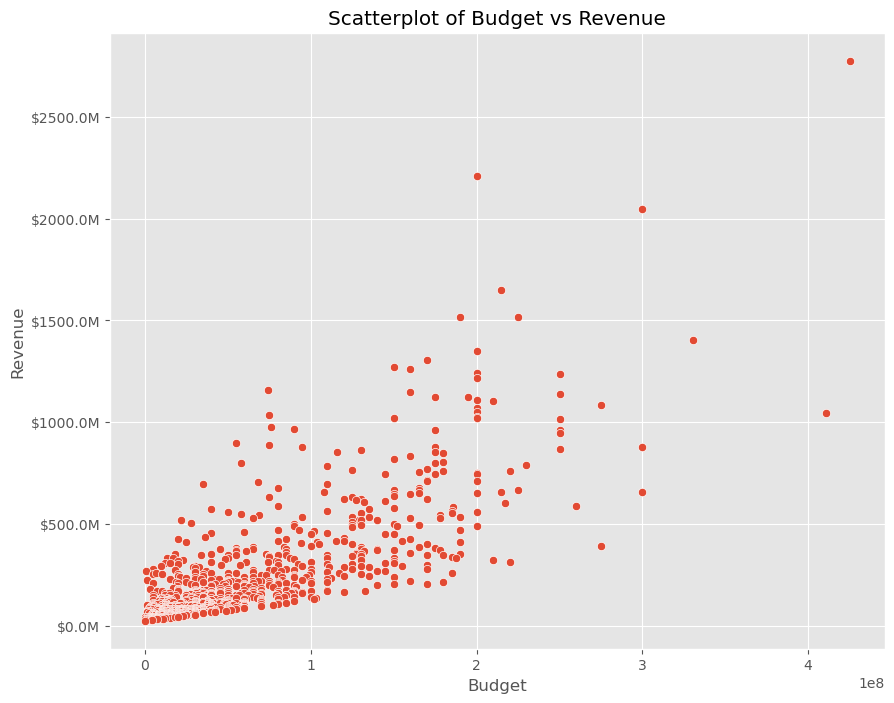

In [29]:
def custom_formatter(x, pos):
    return f'${x / 1e6:.1f}M'

def visualize_df_scatter():
    fig, ax = plt.subplots(figsize=(10,8))
    sns.scatterplot(data=df, x='budget', y='revenue')
    plt.title('Scatterplot of Budget vs Revenue')
    plt.xlabel('Budget')
    plt.ylabel('Revenue')  
    formatter = FuncFormatter(custom_formatter)
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.show()

visualize_df_scatter()

The scatterplots show positive correlations between budget and both revenue and profit, indicating that higher-budget movies tend to generate higher returns. However, clusters of lower-budget movies with lower returns and a few high-budget outliers suggest variability. This means investing in high-budget films can be profitable but risky. A balanced approach with low to mid-budget films could mitigate risk.

#### Heatmap Correlations

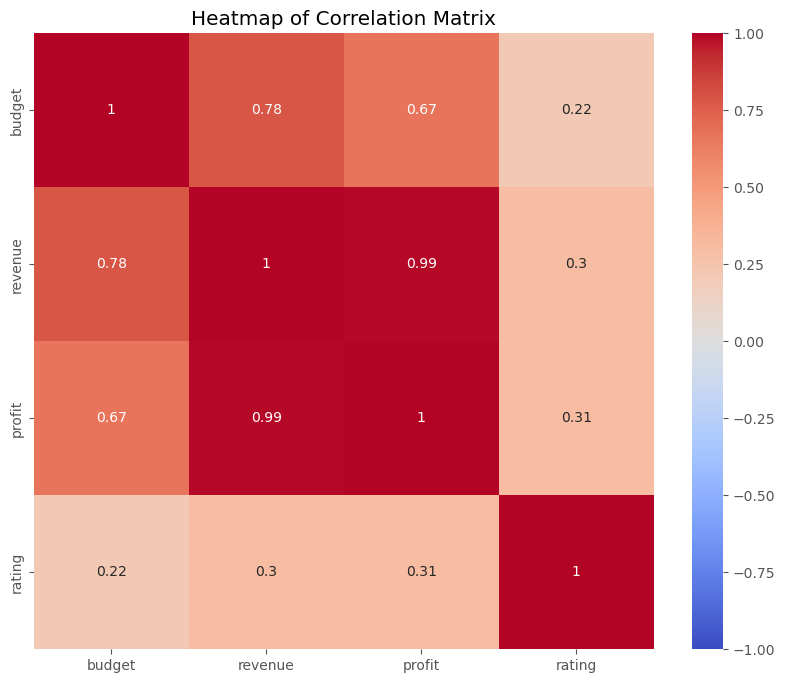

In [30]:
def visualize_df_heatmap():
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[['budget', 'revenue', 'profit', 'rating']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Heatmap of Correlation Matrix')
    plt.show()

visualize_df_heatmap()

With the heatmap, we can see strong positive correlations between budget and both revenue (0.77) and profit (0.66), indicating higher budgets tend to generate higher returns. However, the low correlation between budget and rating (0.2) shows higher budgets do not guarantee better ratings. This means investing in high-budget films can yield higher financial returns but not necessarily higher ratings. We can interpret that focusing on revenue-maximizing strategies enhances profitability, while improving content quality is key for better ratings.

#### Pairplots

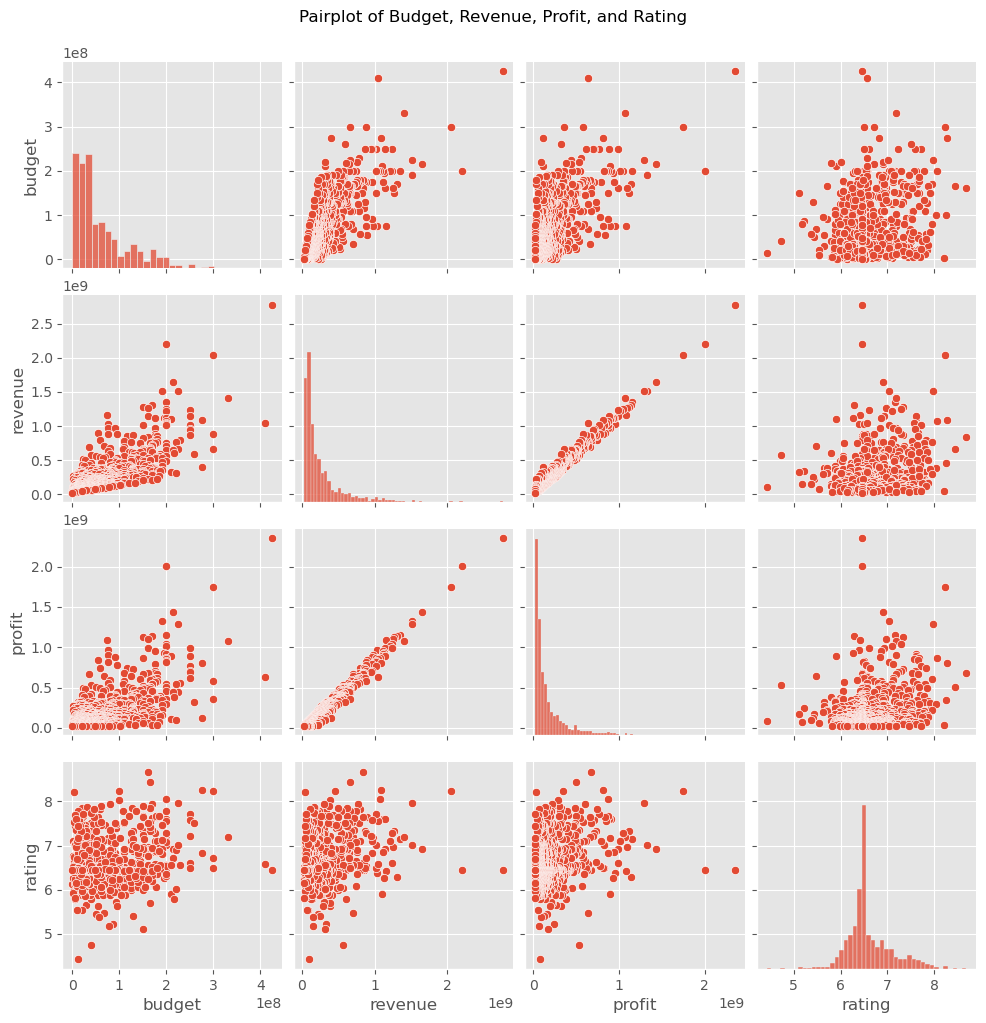

In [31]:
def visualize_df_pairplot():
    sns.pairplot(df[['budget', 'revenue', 'profit', 'rating']])
    plt.suptitle('Pairplot of Budget, Revenue, Profit, and Rating', y=1.02)
    plt.show()

visualize_df_pairplot()

With the pairplot, we can see upward trends indicating positive correlations between budget and both revenue and profit. This means higher budgets tend to generate higher returns. However, clusters of lower budgets with lower returns and a few high-budget outliers suggest variability. This shows that while high-budget films can earn high returns, many lower-budget movies exist. We can interpret that higher budgets generally correlate with higher financial returns, suggesting that investing more in production might be beneficial. However, the presence of outliers indicates risks, so a balanced portfolio of low to mid-budget movies could mitigate these risks.

#### Groupby Comparisons

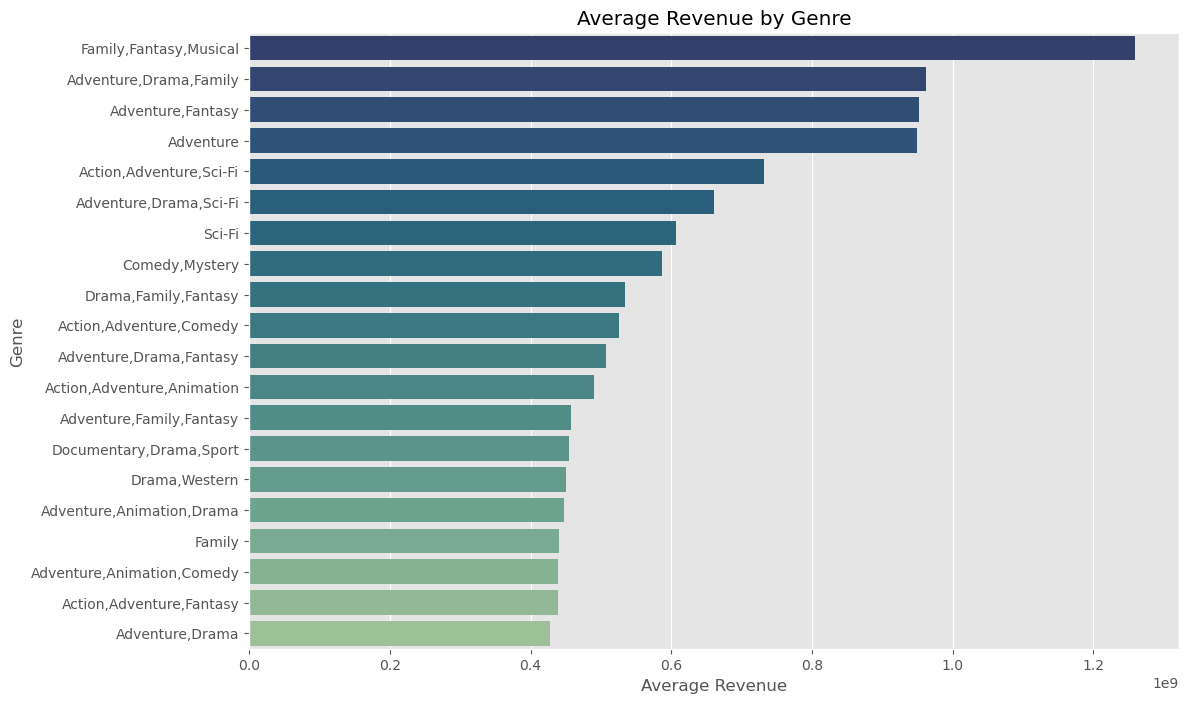

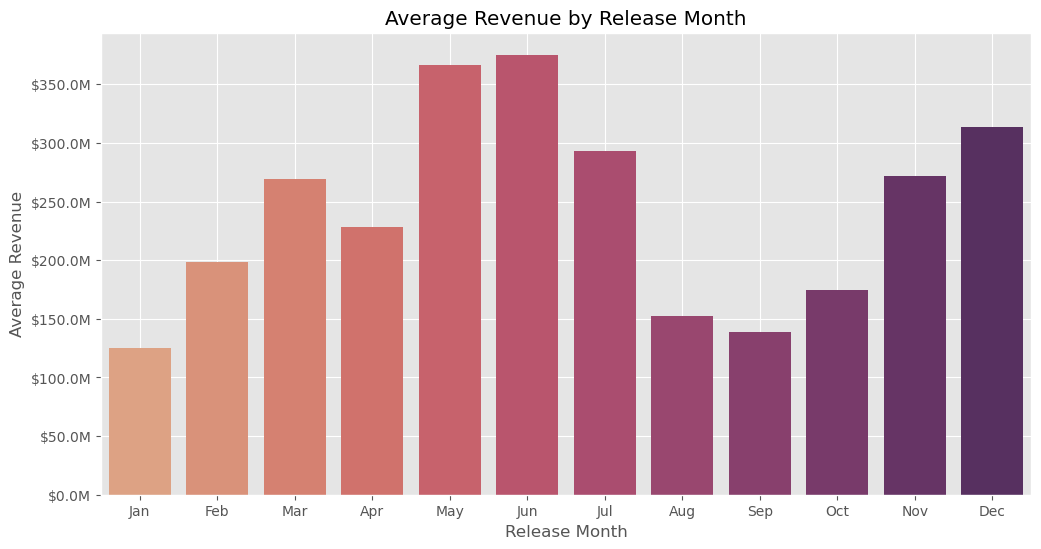

In [32]:
def visualize_df_genre_revenue():
    genre_revenue = df.groupby('genres')['revenue'].mean()
    genre_revenue.sort_values(ascending=False, inplace=True)
    genre_revenue = genre_revenue.head(20)
    plt.figure(figsize=(12, 8))
    sns.barplot(x=genre_revenue.values, y=genre_revenue.index, palette='crest_r')
    plt.title('Average Revenue by Genre')
    plt.xlabel('Average Revenue')
    plt.ylabel('Genre')
    plt.show()

visualize_df_genre_revenue()


def visualize_df_release_revenue():
    monthly_revenue = df.groupby('release_month')['revenue'].mean().reset_index(drop=True).copy()
    plt.figure(figsize=(12, 6))
    sns.barplot(x='release_month', y='revenue', data=df, palette='flare', ci=None)
    plt.title('Average Revenue by Release Month')
    plt.xlabel('Release Month')
    plt.ylabel('Average Revenue')
    plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True)
    formatter = FuncFormatter(custom_formatter)
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.show()

visualize_df_release_revenue()

With the bar plot of average revenue by genre, we can visually see that genres like Fantasy, Romance, and Adventure, Drama, Sport generate the highest average revenue. This means that movies within these genres tend to perform better financially. However, there are also other genres with substantial revenue, indicating a diverse range of successful genres. This shows us that focusing on high-revenue genres could enhance profitability. We can interpret that investing in genres like Fantasy and Adventure is beneficial for financial returns, but considering a variety of genres can diversify revenue sources. We recommend balancing investments between these top-performing genres to maximize profitability.

# Formulating Hypotheses

## Hypothesis 1

#### Films with higher budgets tend to have higher box-office revenues.

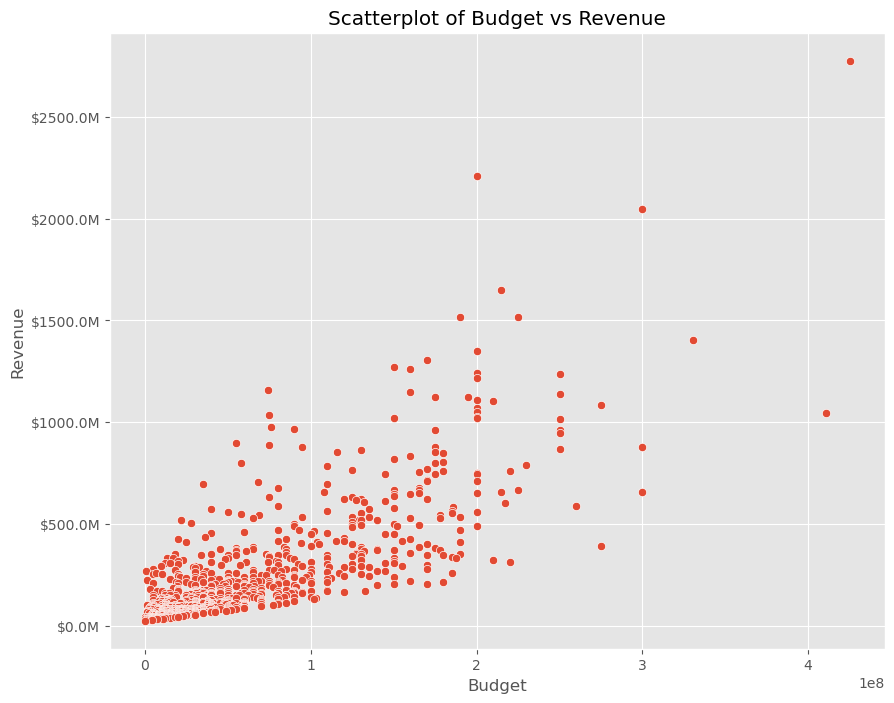

In [33]:
visualize_df_scatter()

## Hypothesis 2

#### Films released during spring months perform better than those released during any other time of the year.

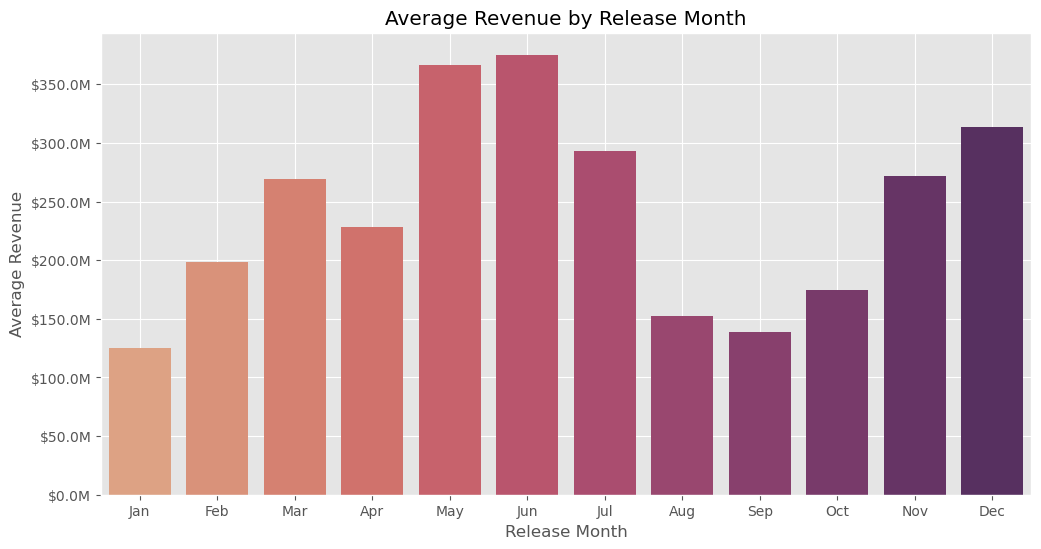

In [34]:
visualize_df_release_revenue()

## Hypothesis 3

#### Certain genres lead to higher revenue than other genres.

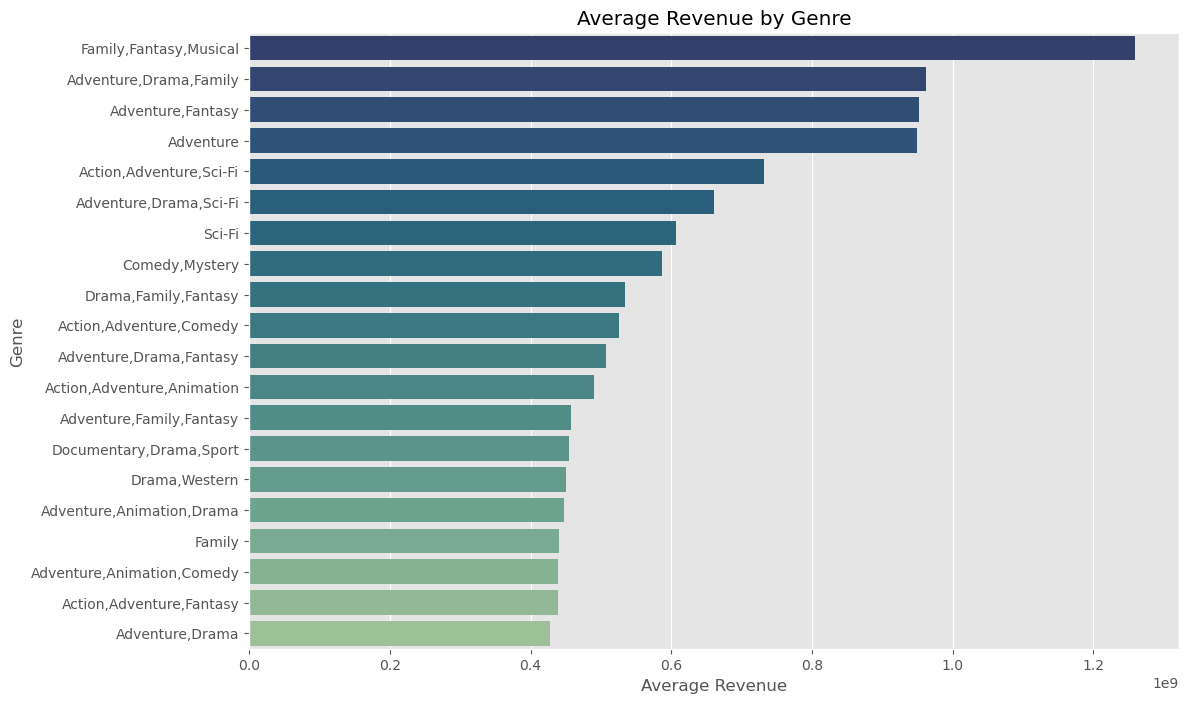

In [35]:
visualize_df_genre_revenue()

# Statistical Analysis

## 1. Movies with higher budgets tend to have higher box-office revenues.

### Correlation Analysis

By calculating the correlation coefficient, we understand the strength and direction of the relationship between budget and revenue. A coefficient closer to +1 indicates a strong positive correlation, meaning higher budgets likely lead to higher revenues.

In [36]:
correlation = df['budget'].corr(df['revenue'])
print(f'Correlation between budget and revenue: {round(correlation,2)}')

Correlation between budget and revenue: 0.78


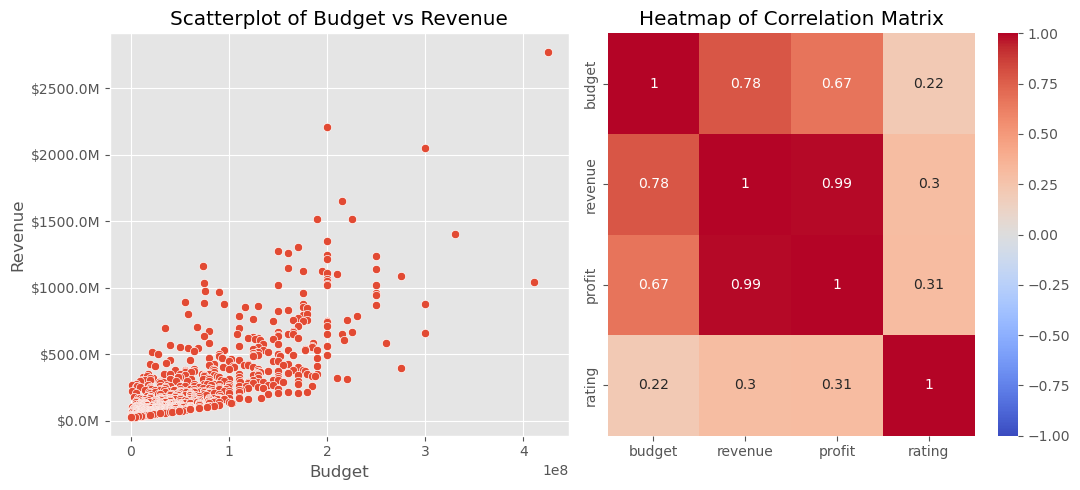

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

sns.scatterplot(data=df, x='budget', y='revenue', ax=axes[0])
axes[0].set_title('Scatterplot of Budget vs Revenue')
axes[0].set_xlabel('Budget')
axes[0].set_ylabel('Revenue')
formatter = FuncFormatter(custom_formatter)
axes[0].yaxis.set_major_formatter(formatter)

correlation_matrix = df[['budget', 'revenue', 'profit', 'rating']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title('Heatmap of Correlation Matrix')

plt.tight_layout()
plt.show()

### Business Implication

The `correlation coefficient` between budget and revenue is `0.78` which tells us that as budget increases, revenue tends to increase as well. **It is worth investing in a higher budget film as it could likely lead to higher box-office revenues.** While correlation does not imply causation, this high correlation coefficient suggests that budget is a good predictor of revenue.

## 2. Films released during spring months perform better than other seasons.

### T-test

By utilizing the statistical T-test, we compare the average revenue of films released in spring (March, April, May) to those released in other months. This will show if spring films have a significant financial advantage over other times of the year.

In [38]:
from scipy.stats import ttest_ind

spring_months = [3, 4, 5]
summer_months = [6, 7, 8]
fall_months = [9, 10, 11]
winter_months = [12, 1, 2]

spring_revenue = df[df['release_month'].isin(spring_months)]['revenue']
summer_revenue = df[df['release_month'].isin(summer_months)]['revenue']
fall_revenue = df[df['release_month'].isin(fall_months)]['revenue']
winter_revenue = df[df['release_month'].isin(winter_months)]['revenue']
other_revenue = df[~df['release_month'].isin(spring_months)]['revenue']

df['season'] = df['release_month'].apply(
    lambda x: 'Spring' if x in spring_months else 
              'Summer' if x in summer_months else 
              'Fall' if x in fall_months else 
              'Winter'
)

t_stat, p_val = ttest_ind(spring_revenue, other_revenue)
print(f'T-statistic: {t_stat}, P-value: {p_val}')

T-statistic: 2.2274083467843964, P-value: 0.026169372030560103


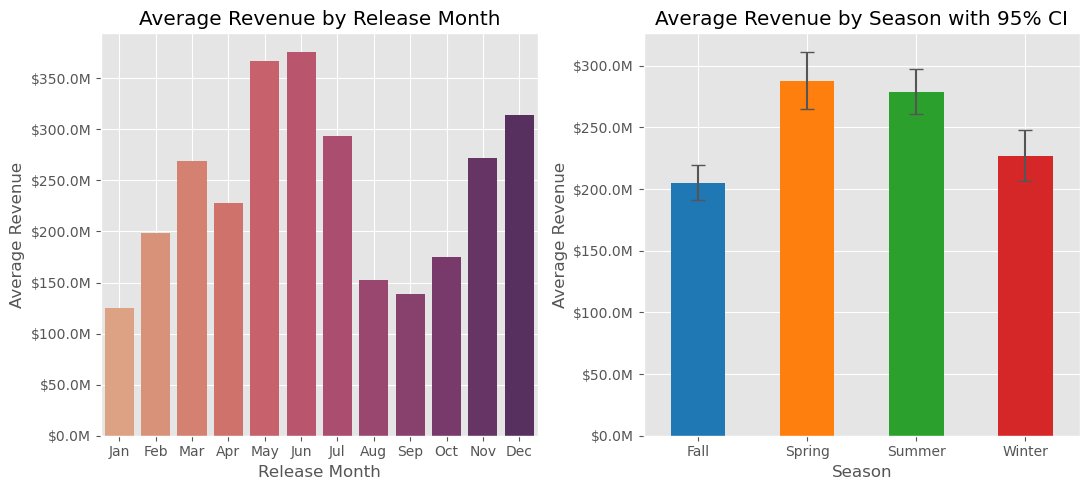

In [39]:
season_means = df.groupby('season')['revenue'].mean()
season_std_errors = df.groupby('season')['revenue'].sem()

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

monthly_revenue = df.groupby('release_month')['revenue'].mean().reset_index(drop=True).copy()
sns.barplot(x='release_month', y='revenue', data=df, palette='flare', ci=None, ax=axes[0])
axes[0].set_title('Average Revenue by Release Month')
axes[0].set_xlabel('Release Month')
axes[0].set_ylabel('Average Revenue')
axes[0].set_xticks(range(12))
axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[0].grid(True)
axes[0].yaxis.set_major_formatter(FuncFormatter(custom_formatter))

season_means.plot(kind='bar', yerr=season_std_errors, capsize=5, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], ax=axes[1])
axes[1].set_title('Average Revenue by Season with 95% CI')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Average Revenue')
axes[1].yaxis.set_major_formatter(FuncFormatter(custom_formatter))
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### Confidence Interval of the `difference` in the `mean` of spring and other months.

By calculating the confidence intervals of the difference in the mean revenue between spring and other months, we quantify the precision and reliability of this difference, confirming that the observed higher average revenue in spring is statistically significant.

In [40]:
mean_spring = np.mean(spring_revenue)
mean_other = np.mean(other_revenue)
std_spring = np.std(spring_revenue)
std_other = np.std(other_revenue)

n_spring = len(spring_revenue)
n_other = len(other_revenue)
stderr_diff = np.sqrt((std_spring**2 / n_spring) + (std_other**2 / n_other))
t_critical = stats.t.ppf(1 - 0.025, df=n_spring + n_other - 2)
margin_err = t_critical * stderr_diff
mean_diff = mean_spring - mean_other
ci_lower = mean_diff - margin_err
ci_upper = mean_diff + margin_err
print(f'Spring Months average revenue: {mean_spring}')
print(f'Other Months average revenue: {mean_other}')
print(f'Difference In average revenue: {mean_diff}')
print('--------')
print(f'95% confidence interval for the difference in means: [{ci_lower}, {ci_upper}]')

Spring Months average revenue: 287969298.39805824
Other Months average revenue: 237669153.53498542
Difference In average revenue: 50300144.86307281
--------
95% confidence interval for the difference in means: [1216508.8646351695, 99383780.86151046]


### Business Implication

Our `p-value` of `0.002896` concludes that we reject the null hypothesis because our `p-value < 0.05` significance level. Coupled with our `t-stat` score `2.9847`, this shows that the average revenue between films released in spring is significantly higher than the average revenue of other times of the year. **Releasing films in the spring could be financially advantageous.**

By further calculating the `spring months average revenue` and the `other months average revenue`, we can truly see if the spring months lead to higher. We calculated the `difference in averages` to see how much spring is different from the other months as well as the `confidence interval of difference in averages` to provide additional support in defending that releasing films in spring could lead to financial advantages.

## 3. Certain genres lead to higher revenue than other genres.

### ANOVA-test

By utilizing the statistical ANOVA-test, we are able to compare the mean profits across different genres. This will show if there are significant differences in profitability among genres, helping us identify which genres tend to be more profitable.

In [41]:
from scipy.stats import f_oneway
genre_groups = [group['revenue'].values for name, group in df.groupby('genres')]
f_stat, p_val = f_oneway(*genre_groups)
print(f'F-statistic: {f_stat}, P-value: {p_val}')

F-statistic: 2.833800460246504, P-value: 5.198004278422785e-23


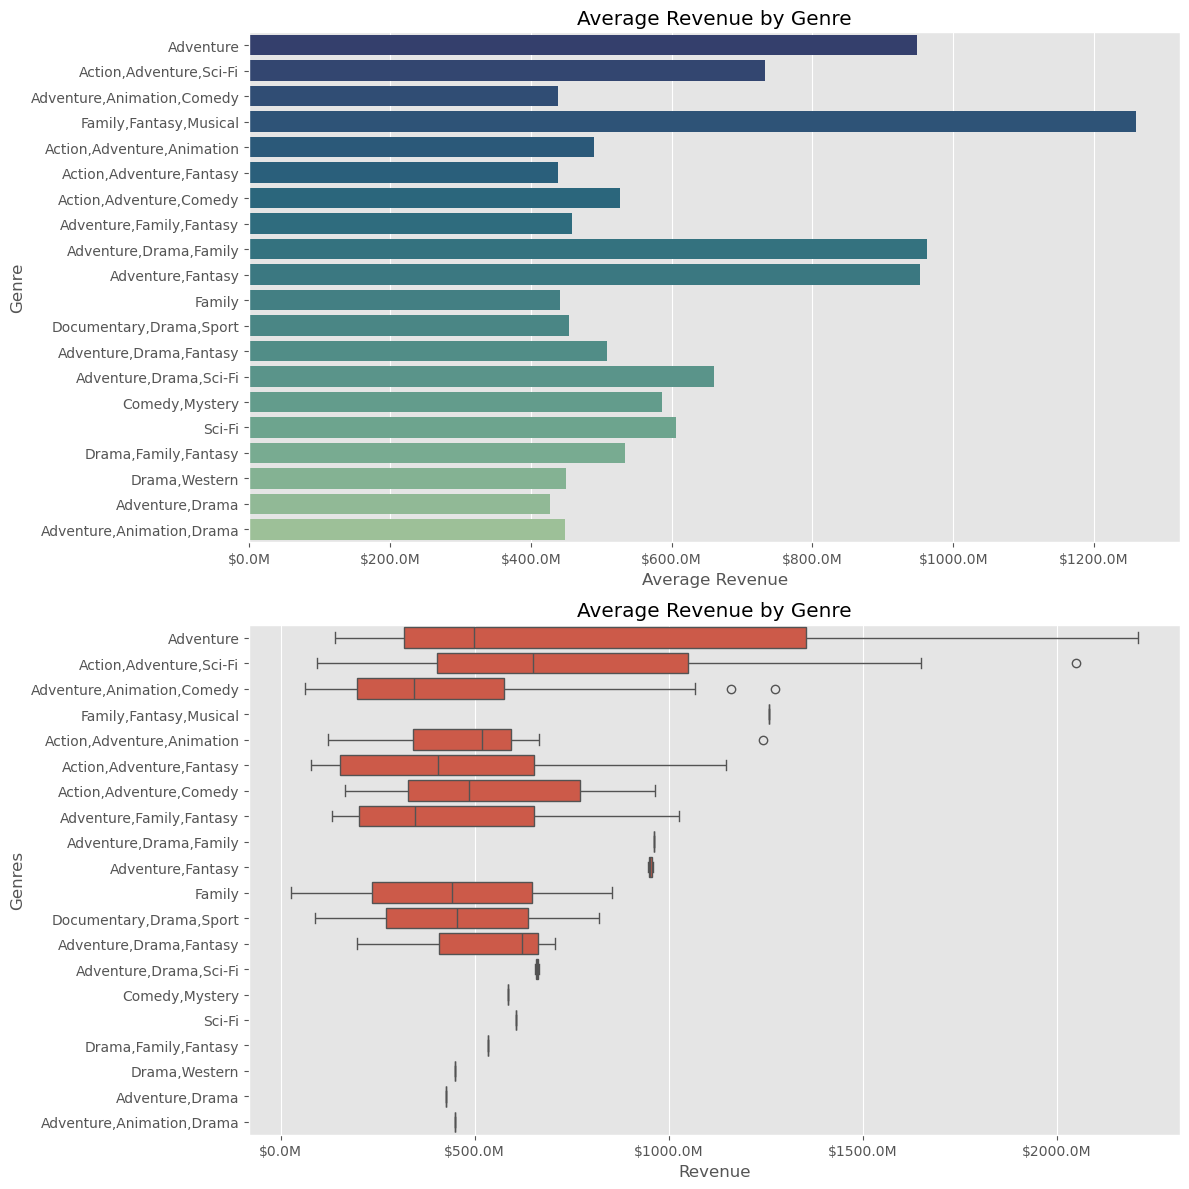

In [42]:
average_revenue = df.groupby('genres')['revenue'].mean().reset_index()
std_revenue = df.groupby('genres')['revenue'].std().reset_index()
top_genres = average_revenue.nlargest(20, 'revenue')['genres']
df_top_genres = df[df['genres'].isin(top_genres)]
average_revenue_top = average_revenue[average_revenue['genres'].isin(top_genres)].set_index('genres')
std_revenue_top = std_revenue[std_revenue['genres'].isin(top_genres)].set_index('genres')
average_revenue_top = average_revenue_top.loc[std_revenue_top.index]

fig, axes = plt.subplots(2, 1, figsize=(12, 12))

sns.barplot(data=df_top_genres, x='revenue', y='genres', palette='crest_r', ci=None, ax=axes[0])
axes[0].set_title('Average Revenue by Genre')
axes[0].set_xlabel('Average Revenue')
axes[0].set_ylabel('Genre')
axes[0].xaxis.set_major_formatter(formatter)

sns.boxplot(x='revenue', y='genres', data=df_top_genres, ax=axes[1])
axes[1].set_title('Average Revenue by Genre')
axes[1].set_xlabel('Revenue')
axes[1].set_ylabel('Genres')
axes[1].xaxis.set_major_formatter(formatter)


plt.tight_layout()
plt.savefig('images/hypothesis3_graph.png')
plt.show()

### Business Implication

Our ANOVA test concluded that our data with genres resulted in `p-value` of `3.53x10e-7` (a significantly small decimal), which means we `reject` our `null hypothesis` because the `p-value < 0.05 significance level`. Our `f-stat` score `3.3958` shows that there is a `significant difference` in average revenue among different `genres`, which is supported by the p-value as well. **Thus, we can allocate our film budget towards a specific genre that will likely result in greater revenue.** 

# Actionable Insights

### 1. Plan for higher budget production to maximize returns.

`Insight:` We observed that budget plays a significant role in a film's success, with higher budgets generally correlating with higher revenues. This was supported by the positive trend on the scatterplot and correlation coefficient close to +1.

`Recommendation:` Plan and allocate for higher budgets on our films to maximize potential revenue.

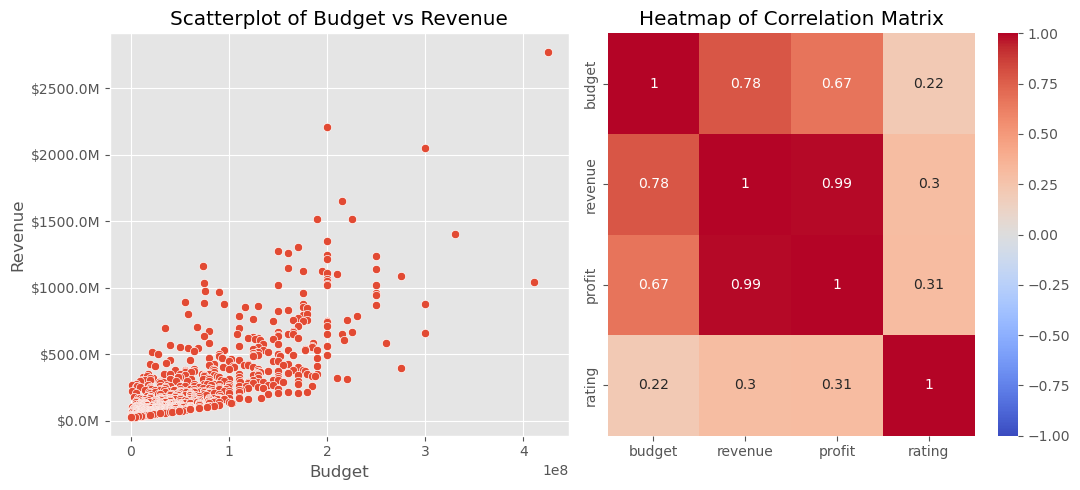

In [43]:
def hypothesis1_graph():
    fig, axes = plt.subplots(1, 2, figsize=(11, 5))
    
    sns.scatterplot(data=df, x='budget', y='revenue', ax=axes[0])
    axes[0].set_title('Scatterplot of Budget vs Revenue')
    axes[0].set_xlabel('Budget')
    axes[0].set_ylabel('Revenue')
    formatter = FuncFormatter(custom_formatter)
    axes[0].yaxis.set_major_formatter(formatter)
    
    correlation_matrix = df[['budget', 'revenue', 'profit', 'rating']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
    axes[1].set_title('Heatmap of Correlation Matrix')
    
    plt.tight_layout()
    plt.show()

hypothesis1_graph()


### 2. Releasing films during the spring months can create more sales.

`Insight:` We observed statistical significance of films released in the spring months and revenue earned compared to the other times of the year. This was supported by our p-value > 0.05 rejecting the null hypothesis that there's no difference of revenues in the spring months compared to other months.

`Recommendation:` Plan major releases during these months to capitalize on higher audience and box-office turnout.

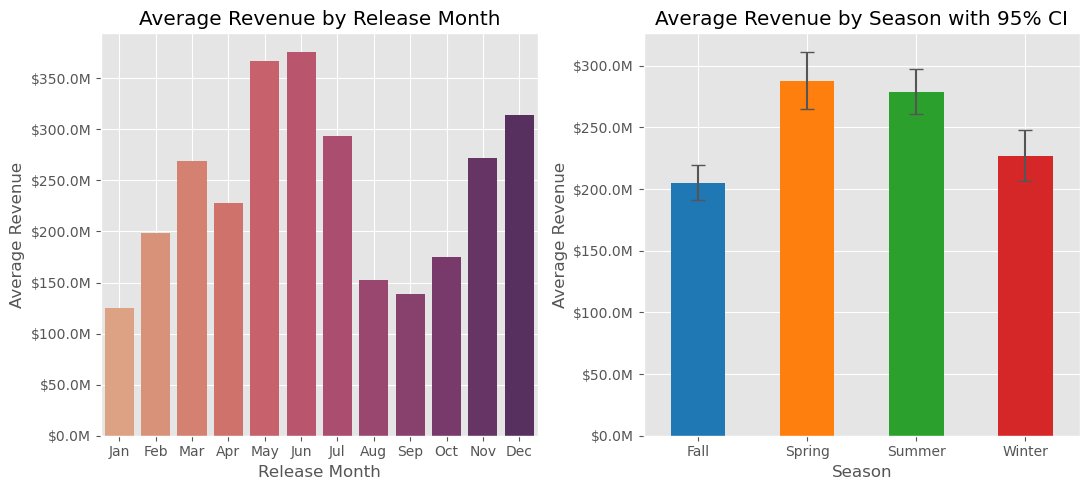

In [44]:
def hypothesis2_graph():
    season_means = df.groupby('season')['revenue'].mean()
    season_std_errors = df.groupby('season')['revenue'].sem()
    
    fig, axes = plt.subplots(1, 2, figsize=(11, 5))
    
    monthly_revenue = df.groupby('release_month')['revenue'].mean().reset_index(drop=True).copy()
    sns.barplot(x='release_month', y='revenue', data=df, palette='flare', ci=None, ax=axes[0])
    axes[0].set_title('Average Revenue by Release Month')
    axes[0].set_xlabel('Release Month')
    axes[0].set_ylabel('Average Revenue')
    axes[0].set_xticks(range(12))
    axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    axes[0].grid(True)
    axes[0].yaxis.set_major_formatter(FuncFormatter(custom_formatter))
    
    season_means.plot(kind='bar', yerr=season_std_errors, capsize=5, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], ax=axes[1])
    axes[1].set_title('Average Revenue by Season with 95% CI')
    axes[1].set_xlabel('Season')
    axes[1].set_ylabel('Average Revenue')
    axes[1].yaxis.set_major_formatter(FuncFormatter(custom_formatter))
    axes[1].tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()

hypothesis2_graph()

### 3. Focus production towards profitable and compelling genres.

`Insight:` We observed a significant difference in the average revenues across various genres, giving us direction for production. This was supported by our p-value > 0.05 rejecting the null hypothesis that there's no difference in revenues across different genres, revealing genres with great value for production.

`Recommendation:` Produce films with aspects of the genre-groups that are proven to drive success.

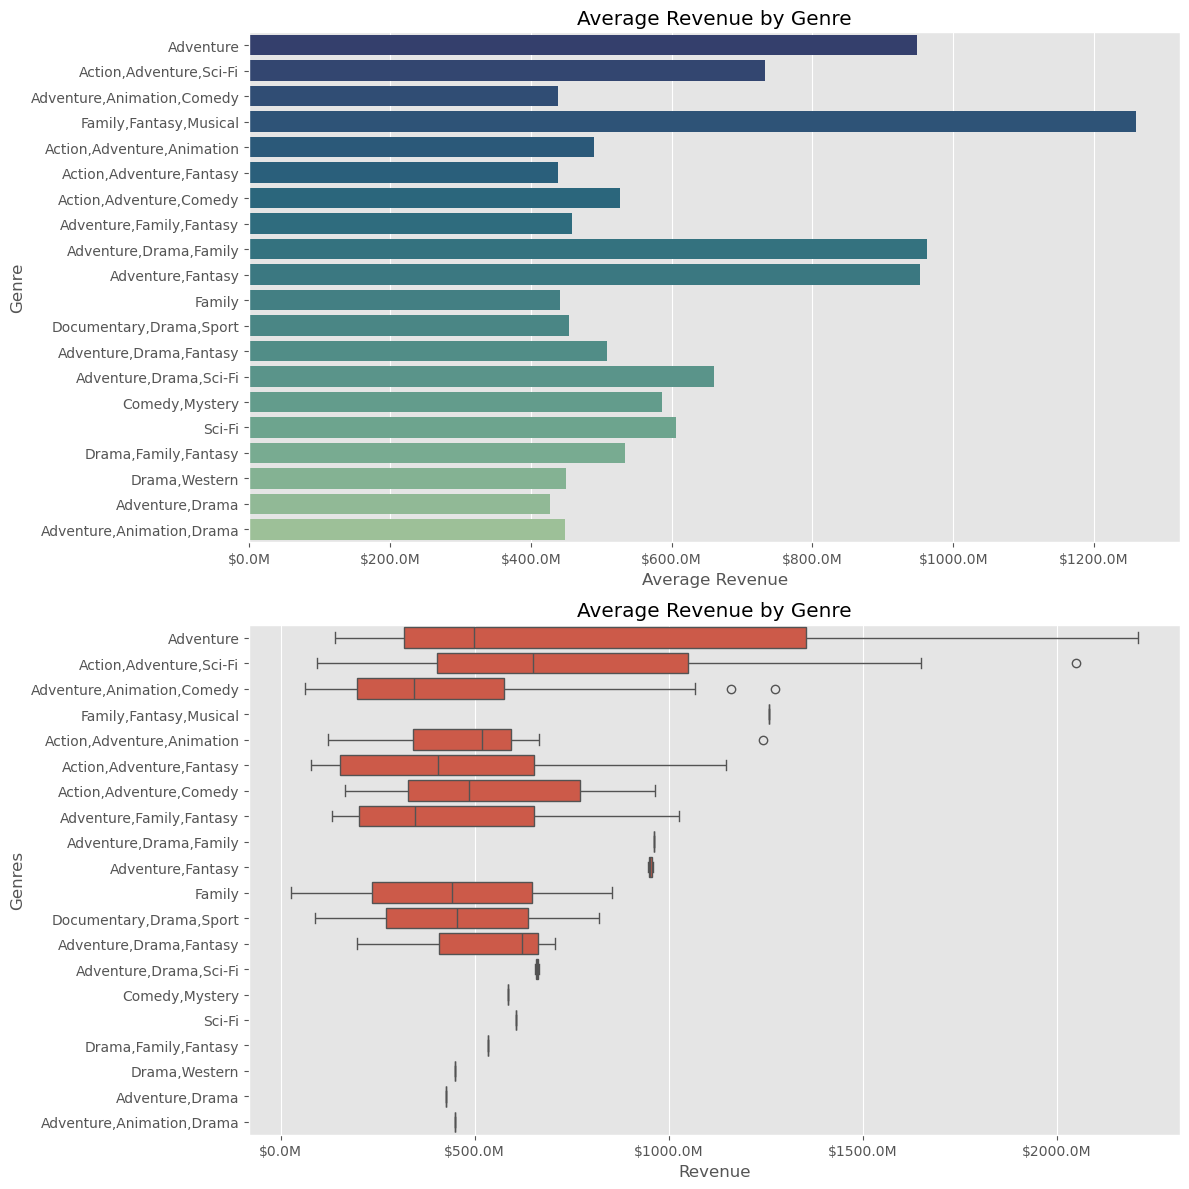

In [45]:
def hypothesis3_graph():
    average_revenue = df.groupby('genres')['revenue'].mean().reset_index()
    std_revenue = df.groupby('genres')['revenue'].std().reset_index()
    top_genres = average_revenue.nlargest(20, 'revenue')['genres']
    df_top_genres = df[df['genres'].isin(top_genres)]
    average_revenue_top = average_revenue[average_revenue['genres'].isin(top_genres)].set_index('genres')
    std_revenue_top = std_revenue[std_revenue['genres'].isin(top_genres)].set_index('genres')
    average_revenue_top = average_revenue_top.loc[std_revenue_top.index]
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    
    sns.barplot(data=df_top_genres, x='revenue', y='genres', palette='crest_r', ci=None, ax=axes[0])
    axes[0].set_title('Average Revenue by Genre')
    axes[0].set_xlabel('Average Revenue')
    axes[0].set_ylabel('Genre')
    axes[0].xaxis.set_major_formatter(formatter)
    
    sns.boxplot(x='revenue', y='genres', data=df_top_genres, ax=axes[1])
    axes[1].set_title('Average Revenue by Genre')
    axes[1].set_xlabel('Revenue')
    axes[1].set_ylabel('Genres')
    axes[1].xaxis.set_major_formatter(formatter)
    
    plt.tight_layout()
    plt.show()

hypothesis3_graph()

# Next Steps

- #### Implement predictive modeling and linear regression analysis to forecast movie revenues based on budget, genre, and release timing, providing stakeholders with data-driven revenue predictions.

- #### Explore other features and variables such as ratings and reviews to uncover additional factors that influence movie success, enhancing the overall predictive model.

- #### Apply optimization techniques for effective budget allocation, ensuring resources are used in a way that maximizes potential returns on investment.

#### Test Entire Script

In [46]:
try:
    print('Script executed successfully!')
except:
    print('FAILED!')

Script executed successfully!
